In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, autograd as ag
from tqdm import tqdm
from copy import deepcopy

from model import *
from utils import *
from dataset import *

In [2]:
hyperparams = {
        'n_tasks': 1000,
        'n_episode': 150,
        'n_timesteps': 10,
        'input_dim': 2,
        'hidden_dim': 512,
        'output_dim': 2,
        'lr': 1e-4,
        'batch_size': 128,
        'n_epochs': 100,
        }

# Pretraining Data Simulation

In [3]:
def get_loader(batch_size=hyperparams['batch_size'], n_tasks=hyperparams['n_tasks'], 
                set_seed: Union[int, None]=None, shuffle: bool=True):
    dataset = TwoArmLinkTrainDataset(n_tasks=n_tasks, n_episode=hyperparams['n_episode'], n_timesteps=hyperparams['n_timesteps'], set_seed=set_seed)
    data_loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            pin_memory=True,
                            drop_last=True,
                            )
    return data_loader

# Multi-Task Training

In [4]:
train_loader = get_loader(set_seed=0, shuffle=True)

100%|██████████| 1000/1000 [00:11<00:00, 85.79it/s]


Two Arm Link Dataset Generation Finished!


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(input_dim=hyperparams['input_dim'], output_dim=hyperparams['output_dim'], hidden_dim=hyperparams['hidden_dim']).to(device)
model = model.double()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])
criterion = nn.MSELoss()

In [6]:
def train_multi_task(data_loader=train_loader, nb_epochs=hyperparams['n_epochs']):
    total_loss = []
    for epoch in range(1, nb_epochs + 1):
    	# store the loss in each batch
        losses = []
        # use tqdm to better visualize the training process
        with tqdm(data_loader, unit="batch") as tepoch: # evaluate every batch
            for data in tepoch:
                tepoch.set_description(f"Epoch {epoch}") # custome the printed message in tqdm
                x = data['angle'].to(device)
                y = data['true_pos'].to(device)
                optimizer.zero_grad()
                output = model.forward(x)
                loss = criterion(output, y)
                loss.backward() # backward propagation
                optimizer.step() # update parameters
                losses.append(loss.item())
                # custome what is printed in tqdm message
                tepoch.set_postfix(loss=sum(losses)/len(losses))
        total_loss.append(sum(losses)/len(losses))
    return total_loss

In [ ]:
total_loss = train_multi_task(nb_epochs=10) # return a list of loss in different epochs

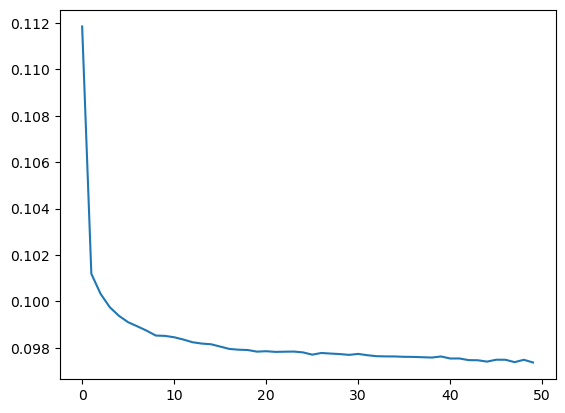

In [16]:
plt.plot(total_loss)

In [15]:
# save parameters and optimizer
torch.save({
    'state_dict': model.state_dict(),
    'loss': total_loss,
    'optimizer' : optimizer.state_dict(),
}, 'Task1_multiTask.pth.tar')

# Reptile Training

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reptile = MyModel(input_dim=hyperparams['input_dim'], output_dim=hyperparams['output_dim'], hidden_dim=hyperparams['hidden_dim']).to(device)
model_reptile = model_reptile.double()
model_reptile.train()
optimizer_reptile = torch.optim.Adam(model_reptile.parameters(), lr=hyperparams['lr'])
criterion = nn.MSELoss()

In [39]:
train_dataset_reptile = TwoArmLinkTrainDataset(n_tasks=hyperparams['n_tasks'], n_episode=hyperparams['n_episode'], n_timesteps=hyperparams['n_timesteps'], set_seed=0)

100%|██████████| 1000/1000 [00:11<00:00, 83.45it/s]


Two Arm Link Dataset Generation Finished!


In [47]:
seed = 0
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

In [48]:
def train_reptile(dataset=train_dataset_reptile, nb_epochs=hyperparams['n_epochs']):
    def totorch(x):
        return ag.Variable(torch.DoubleTensor(x).to(device))
        
    def train_on_batch(x, y):
        x = totorch(x)
        y = totorch(y)
        optimizer_reptile.zero_grad()
        ypred = model_reptile.forward(x)
        loss = criterion(ypred, y)
        loss.backward()
        optimizer_reptile.step()
        return loss

    batch_size = hyperparams['batch_size']
    meta_step_size = 0.02
    n_episode = hyperparams['n_episode']
    n_task = hyperparams['n_tasks']
    n_timestep = hyperparams['n_timesteps']
    history = []
    for epoch in range(nb_epochs):
        losses = []
        with tqdm(range(n_task), unit='task') as tepoch:
            for meta_iter in tepoch:
                tepoch.set_description(f'Epoch {epoch}')
                x_train = dataset.q[meta_iter*n_episode*n_timestep:(meta_iter+1)*n_episode*n_timestep]
                y_train = dataset.x[meta_iter*n_episode*n_timestep:(meta_iter+1)*n_episode*n_timestep]

                weights_before = deepcopy(model_reptile.state_dict())
                inds = rng.permutation(len(x_train))
                for start in range(0, len(x_train), batch_size):
                    mbinds = inds[start:start+batch_size]
                    losses.append(train_on_batch(x_train[mbinds], y_train[mbinds]))
                # Interpolate between current weights and trained weights from this task
                # I.e. (weights_before - weights_after) is the meta-gradient
                weights_after = model_reptile.state_dict()
                outerstepsize = meta_step_size * (1 - meta_iter / n_task) # linear schedule
                model_reptile.load_state_dict({name: 
                    weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
                    for name in weights_before})

                loss = sum(losses) / len(losses)
                # print(f"Epoch: {epoch}, Loss: {loss.item()}")
                tepoch.set_postfix(loss=loss.item())
        history.append(loss.item())
    return history

In [49]:
loss_reptile = train_reptile(nb_epochs=10)

Epoch 27:  22%|██▏       | 221/1000 [00:34<01:59,  6.50task/s, loss=0.1]   


KeyboardInterrupt: 

In [13]:
# save parameters and optimizer
torch.save({
    'state_dict': model_reptile.state_dict(),
    'loss': loss_reptile,
    'optimizer' : optimizer_reptile.state_dict(),
}, 'Task1_reptile.pth.tar')

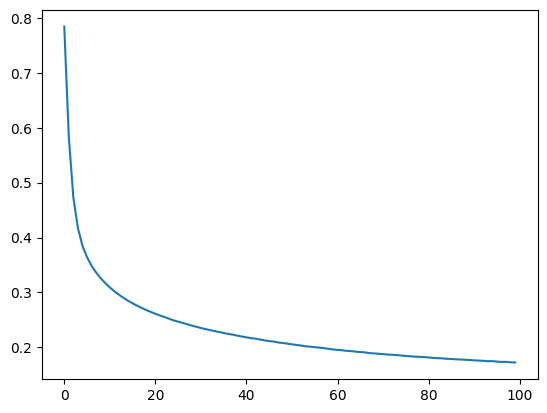

In [12]:
plt.plot(loss_reptile)

# Load model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)
checkpoint = torch.load('Task1_multiTask.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

MyModel(
  (lin1): Linear(in_features=2, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
  (dropout_for_GD): Dropout(p=0.5, inplace=False)
  (dropout): DropoutLayer()
)

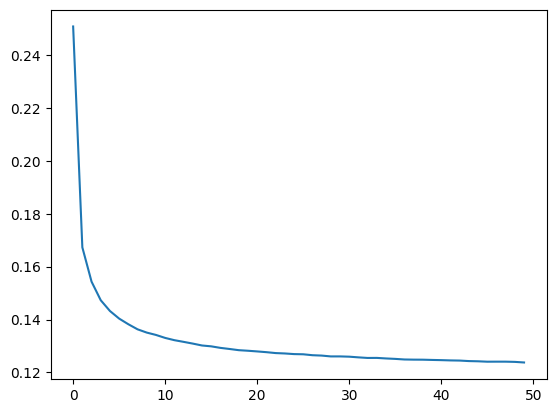

In [8]:
l = checkpoint['loss']
plt.plot(l)